In [50]:

import os
import pandas as pd
import numpy as np
import seaborn  as sns
from plotnine import *
import random
import warnings
import matplotlib.pyplot as plt

from IPython.display import Image

from functools import partial

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 5: The forecaster's toolbox
## 5.2. Some simple forecasting methods 

In practice, simple methods are only useful a references. 

### Mean method 

Forecasts of all future values ($T + h$) are set to be the average of all previous values. 

$$
\hat{y}_{T+h|T} = \bar{y} = \frac{(y_1 + ... + y_T)}{T}
$$

### Naïve method

Each forecast is set to the previous value. 

$$
\hat{y}_{T+h|T} = y_T
$$

### Seasonal naïve method 

Each forecast is set to its value in the prior period of last season. For example, a prediction for a Monday on weekly data would be the value on the prior Monday. Mathematically, the value for the next prediction given all previous $T$ observations, $T + h|T$, is the value from the same $m$ season from the last period, which is defined as the number of complete seasons that have elapsed ($m(k+1)$, where the integer of $k=(k-1)/m$ and is taken). 

$$
\hat{y}_{T+h|T} = y_{T+h - m(k+1)}
$$

### Drift method

Forecasts are set to the average change observed over the entire course of the time series. 

$$
\hat{y}_{T+h|T}  = y_{T+h} + h \Big(\frac{y_t - y_1}{T -1}\Big)
$$

/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2974823842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2974823842.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


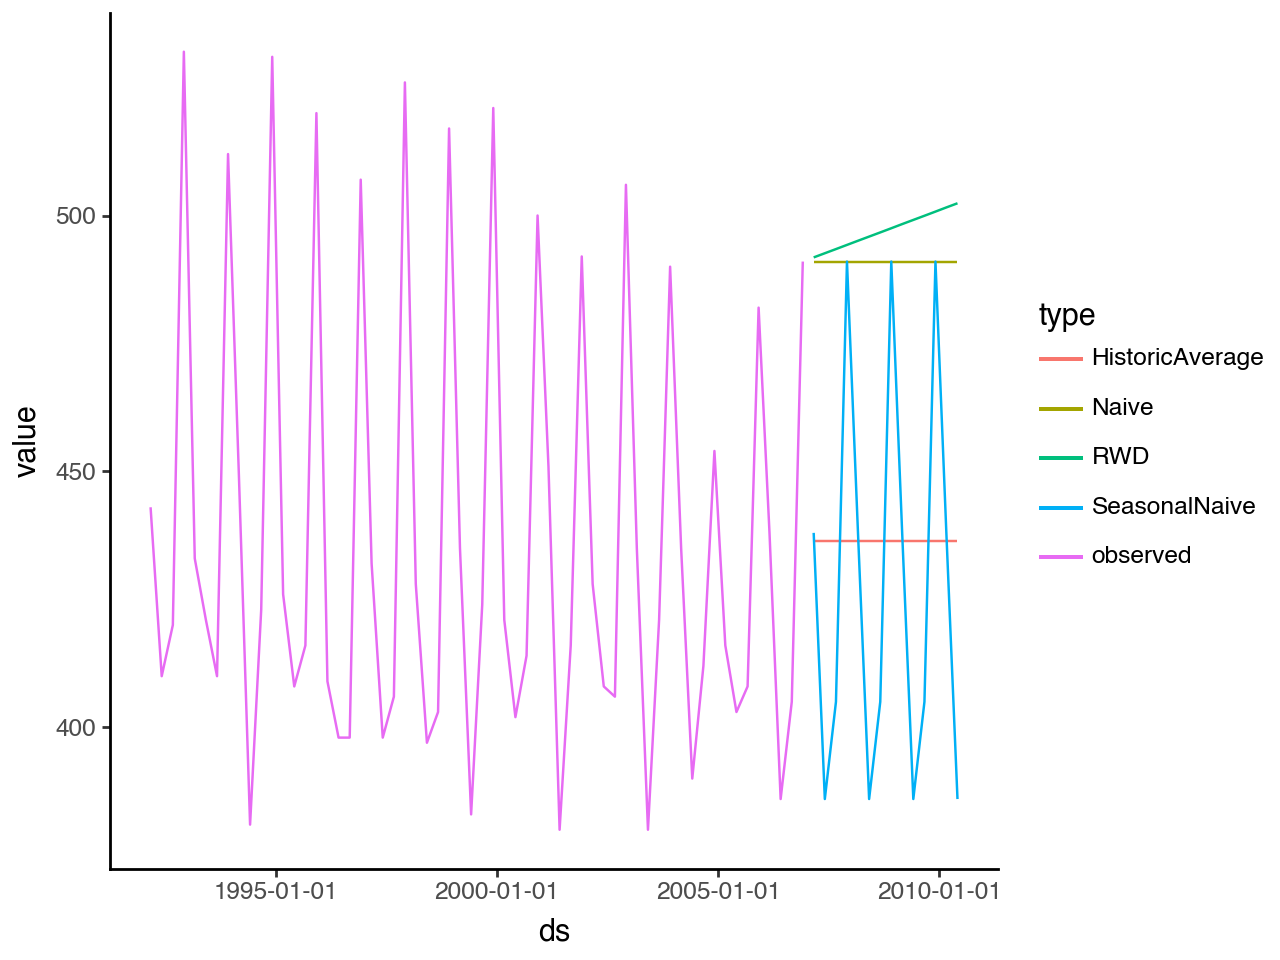

In [33]:
df_aus_beer = pd.read_csv('data/raw/aus_production_formatted.csv')

df_aus_beer = df_aus_beer.query("unique_id == 'Beer' and ds >= '1992-01-01'")
df_train = df_aus_beer[:-14]
df_test = df_aus_beer[-14:]

avg_method = HistoricAverage()
naive_method = Naive()
seasonal_naive_method = SeasonalNaive(4)
drift_method = RandomWalkWithDrift()


sf = StatsForecast(
    models=[avg_method, naive_method, seasonal_naive_method, drift_method], 
    freq=pd.offsets.QuarterBegin(1)
)
sf.fit(df_train)

df_forecast = sf.predict(h=14)
df_forecast["y"] = df_test["y"].values

df_train['type'] = 'observed'
df_train.rename(columns={"y": "value"}, inplace=True)

df_forecast = pd.melt(frame=df_forecast, id_vars=['unique_id', 'ds'], var_name='type', 
                      value_name='value')
df_forecast = df_forecast.loc[~df_forecast['type'].isin([np.nan, 'y'])]

df_merged = pd.concat(objs=[df_train, df_forecast], ignore_index=True)
df_merged['ds'] = pd.to_datetime(df_merged['ds'])

(ggplot(data=df_merged, mapping=aes(x='ds', y='value', group='type', color='type')) + 
 geom_line() + 
 theme_classic())

## 5.3. Fitted values and residuals 

Fitted values are based on all previous values, whereas forecasts can be based on future values. 
Innovation residuals are simply residuals based on transformed variables. 

To obtain fitted values and residuals, set `fitted=True` in `StatsForecast()` 

In [34]:
train = df_aus_beer[:-14]
test = df_aus_beer[-14:]

mean_method = HistoricAverage()
sf = StatsForecast(models=[mean_method], freq="Q")
sf.forecast(h=14, df=train, fitted=True)
fitted_values = sf.forecast_fitted_values()
train["fitted"] = fitted_values["HistoricAverage"].values
train["resid"] = train["y"] - train["fitted"]
train["innov"] = train["y"] - train["fitted"]
train.head()

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2110831483.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2110831483.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,unique_id,ds,y,fitted,resid,innov
144,Beer,1992-03-01,443.0,436.45,6.55,6.55
145,Beer,1992-06-01,410.0,436.45,-26.45,-26.45
146,Beer,1992-09-01,420.0,436.45,-16.45,-16.45
147,Beer,1992-12-01,532.0,436.45,95.55,95.55
148,Beer,1993-03-01,433.0,436.45,-3.45,-3.45


## 5.4. Residual diagnostics

Good forecasting models have residuals that are 

1. Uncorrelated. Correlated residuals suggests there is signal that can be modelled. 
2. Zero mean. Otherwise, forecasts will be biased. 

Importantly, these conditions are not sufficient for creating a good model. Bias is easier to solve than correlatednes (i.e., if biased with mean $m$, $m$ can simply be added to all forecasts). 

The following conditions are useful for constructing reliable prediction intervals: 

3. Constant variance
4. Normally distributed 

Importantly, a model that does not satisfy properties 3) and 4) cannot necessarily be improved. 

### Portmanteau tests for autocorrelation

Examining autocorrelation individually invites Type I errors. To solve this problem, we consider whether the first $l$ autocorrelations differ from a white noice process. This is the **portmanteau test**. There are several statistics to run this test such as the **Box-Piece test** 

$$
Q = T \sum^\ell_{k=1} r^2k_k, 
$$

where $\ell$ is the maximum lag being considered, $T$ is the number of observations. Recommend using $\ell=10$ for non-seasonal data and $\ell=2m$ for seasonal data. That said, test is not useful for large $\ell$ and $\ell$ should be capped at T/5. 

Another method is the **Ljung-Box** test

$$
Q^\ast = T(T+2) \sum^\ell_{k=1} (T-k)^{-1} r^2_k
$$

Q (or $Q^ast$) have a $\chi^2$ distribution when they become too large. 

In the example below, there are considerable autocorrelations among the residuals. 

In [37]:
resid_test = acorr_ljungbox(x=train['resid'].dropna(), boxpierce=True)
resid_test.round(2)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.91,0.34,0.86,0.35
2,28.67,0.00,26.84,0.00
3,29.18,0.00,27.31,0.00
4,78.04,0.00,71.44,0.00
5,78.58,0.00,71.91,0.00
6,105.42,0.00,95.29,0.00
7,106.07,0.00,95.84,0.00
8,154.43,0.00,136.41,0.00
9,155.27,0.00,137.10,0.00
10,180.30,0.00,157.28,0.00


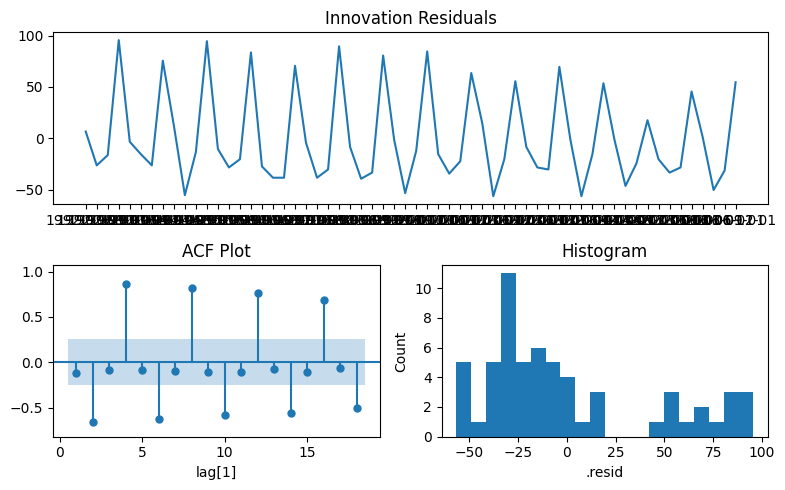

In [52]:
def plot_diagnostics(data):
    fig = plt.figure(figsize=(8, 5))

    ax1 = fig.add_subplot(2, 2, (1, 2))
    ax1.plot(data['ds'], data["resid"])
    ax1.set_title("Innovation Residuals")

    ax2 = fig.add_subplot(2, 2, 3)
    plot_acf(data["resid"].dropna(), ax=ax2, zero=False,
      bartlett_confint=False, auto_ylims=True)
    ax2.set_title("ACF Plot")
    ax2.set_xlabel('lag[1]')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.hist(data["resid"], bins=20)
    ax3.set_title("Histogram")
    ax3.set_xlabel(".resid")
    ax3.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


plot_diagnostics(train)


## 5.5 Distributional forecasts and prediction intervals 
### One-step prediction intervals
For one-step forecasts, prediction intervals can be estimated using the standard deviation of the residuals: 

$$
\hat{\sigma} = \sqrt{\frac{1}{T - K - M}\sum^T_{t=1e^2_t}}, 
$$

where K is the number of parameters and M is the number of missing values (e.g., M=1 for naïve method because there is no value before the first one). 

### Multi-step prediction intervals

A more advanced calculation is needed to $\sigma_h$ for multi-step prediction intervals. Importantly, the following calculations assume uncorrelated residuals. 

### Benchmark methods 

The `statsforecast` package provides convenient computation of multi-step prediction intervals 

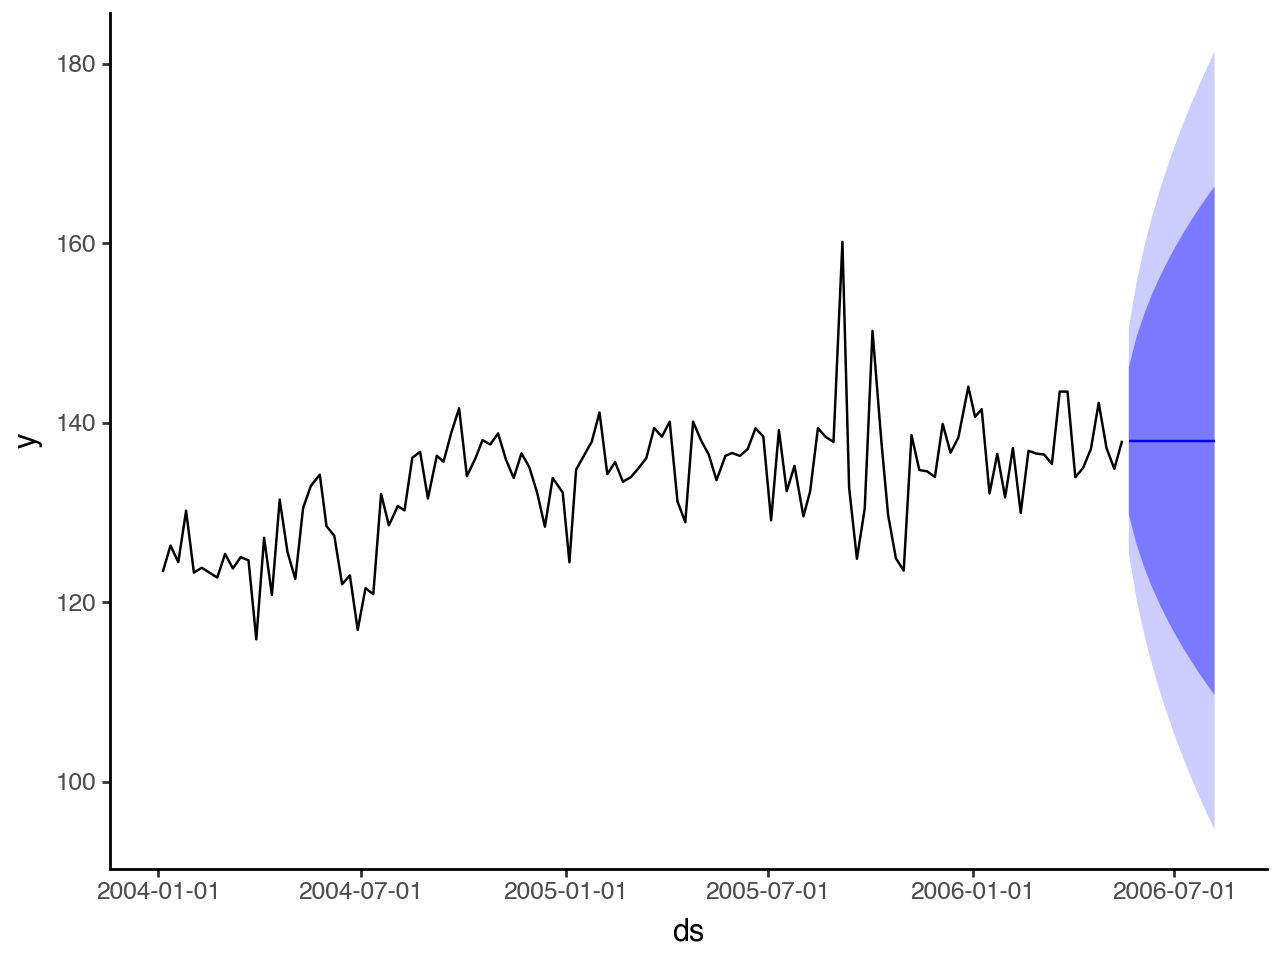

In [109]:
# Run naive forecasting method on Toronto gas prices 
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')
df_toronto.reset_index(inplace=True)

# rename for formatting
df_toronto.rename(columns={"Date": "ds", 
                           "price_2025": "y", 
                           "city": "unique_id"}, inplace=True)

cols = ['ds', 'y', 'unique_id']
df_train = df_toronto[cols][:-1000]
df_test = df_toronto[cols][-1000:]

naive_method = Naive()

sf = StatsForecast(
    models=[naive_method], 
    freq='W')

sf.fit(df_train)

df_forecast = sf.forecast(df=df_train, h=12, level=[80, 95])  # NOTE: forecast for next 3 months (12 weeks)

(ggplot(data=df_train.loc[df_train['ds'].gt('2004')], mapping=aes(x='ds', y='y')) + 
 geom_line() + 
 geom_line(inherit_aes=False, data=df_forecast, 
           mapping=aes(x='ds', y='Naive'), color='blue') + 
 geom_ribbon(inherit_aes=False, data=df_forecast, 
             mapping=aes(x='ds', ymin='Naive-lo-95', ymax='Naive-hi-95'), fill='blue', alpha=0.2) + 
 geom_ribbon(inherit_aes=False, data=df_forecast, 
             mapping=aes(x='ds', ymin='Naive-lo-80', ymax='Naive-hi-80'), fill='blue', alpha=0.4) + 

    # 80% prediction interval shaded area (on top of 90%)
 theme_classic())

In [ ]:
### Bootstrapping 
